# Vehicle Detection

## Imports

In [1]:
import os
import glob
import cv2
import time
import numpy as np

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# kill axis in rcParams
#print(mpl.rcParams.keys())
mpl.rc('image', interpolation='bilinear')
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False);
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
mpl.rc(('xtick','ytick'),color=(1,1,1,0));
# enlarge default figure size
mpl.rc('figure', figsize=(10, 5))

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score

def nowMs():
    return int(round(time.time() * 1000))

## Training the Classifier

### Load Dataset

In [2]:
paths0 = glob.glob('./non-vehicles/**/*.png', recursive=True)
paths1 = glob.glob('./vehicles/**/*.png', recursive=True)

In [3]:
# Experimentally discovered, proven computationally optimal
HOG_ORIENT = 8
HOG_CELL_PER_BLOCK = 1
HOG_PIX_PER_CELL = 8
CLASSIFIER_SZ = 24
HOW_SLIDING_WND_CELLS_STEP = 1

In [4]:
# extract features from a list of images
def extractFeaturesFromFiles(imgs, orient, pix_per_cell, cell_per_block):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for path in imgs:
        file_features = []
        # Read in each one by one
        img = cv2.imread(path)
        
        # Size down the image to reduce feature vector
        img = cv2.resize(img, (CLASSIFIER_SZ, CLASSIFIER_SZ), cv2.INTER_LANCZOS4)
        
        # apply color conversion to YUV
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        for channel in range(feature_image.shape[2]):
            f = hog(feature_image[:,:,channel], orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=False, feature_vector=True)
            hog_features.append(f)
        hog_features = np.ravel(hog_features)

        # Append the new feature vector to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [5]:
features0 = extractFeaturesFromFiles(paths0, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELL_PER_BLOCK)
features1 = extractFeaturesFromFiles(paths1, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELL_PER_BLOCK)

In [6]:
X = np.asarray(features0 + features1, np.float64)
y = np.zeros((len(features0) + len(features1), 1))
y[len(features0):,0] = 1

In [7]:
print('Loaded {} cars and {} non-cars'.format(len(features1), len(features0)))
print('Feature vector shape {}'.format(X.shape))

Loaded 8792 cars and 8968 non-cars
Feature vector shape (17760, 216)


In [8]:
rand_state = np.random.randint(0, 100)
#rand_state = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [9]:
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
print('Number of training samples ', X_train.shape)
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

Number of training samples  (14208, 216)


### Example of HOG features visualization

In [10]:
def visualizeHogFeatures():
    img = cv2.imread(paths1[700])
    img = cv2.resize(img, (CLASSIFIER_SZ, CLASSIFIER_SZ), cv2.INTER_LANCZOS4)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, vis = hog(img, orientations=HOG_ORIENT, 
                 pixels_per_cell=(HOG_PIX_PER_CELL, HOG_PIX_PER_CELL),
                 cells_per_block=(HOG_CELL_PER_BLOCK, HOG_CELL_PER_BLOCK), 
                 transform_sqrt=True, 
                 visualise=True, feature_vector=False)
    vis = vis * 255
    plt.imshow(np.hstack((img, vis)), cmap='gray')

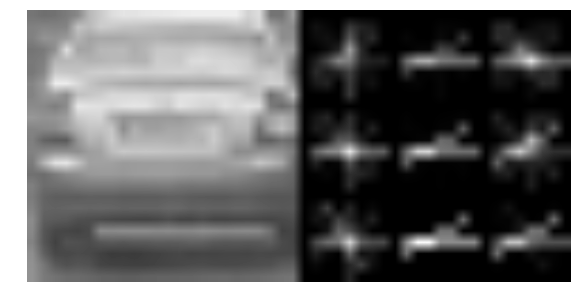

In [11]:
visualizeHogFeatures()

### Train the Classifier

In [12]:
### After experiments, C=1, gamma='auto' seem to be the best to generalize and separate classes
#param_grid = [
#  {'C': [0.1, 1.0, 10.0], 'kernel': ['linear']},
#  {'C': [0.1, 1.0, 10.0], 'kernel': ['rbf'], 'gamma': [0.1, 1.0, 10.0]},
# ]
#svr = svm.SVC()
#clf = GridSearchCV(svr, param_grid, cv=2, n_jobs=-1, verbose=99)
#clf.fit(scaled_X_train, y_train)
#print(clf.best_params_, ' -> score=', clf.best_score_)
#joblib.dump(clf.best_estimator_, 'svm_car.pkl')

In [13]:
clf = svm.SVC()
clf.fit(scaled_X_train, y_train)
joblib.dump(clf, 'svm_car.pkl')

['svm_car.pkl']

### Check score on test set

In [14]:
carSvm = joblib.load('svm_car.pkl')

In [15]:
y_test_pred = carSvm.predict(scaled_X_test)
testScore = accuracy_score(y_test, y_test_pred)
print('SVM test score = ', testScore)

SVM test score =  0.990427927928


## Image Pipeline

### Single scale detector

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def findCars(imgBgr, p1, p2, scale, bVis=False):
    imgDraw = None
    if bVis:
        imgDraw = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2RGB)

    imgRoi = imgBgr[p1[1]:p2[1],p1[0]:p2[0],:]
    
    if scale != 1:
        imgRoi = cv2.resize(imgRoi, (np.int(imgRoi.shape[1]/scale), np.int(imgRoi.shape[0]/scale)), 
                            interpolation=cv2.INTER_AREA)

    imgRoi = cv2.cvtColor(imgRoi, cv2.COLOR_BGR2YUV)

    # Define blocks and steps as above
    nxblocks = (imgRoi.shape[1] // HOG_PIX_PER_CELL) - HOG_CELL_PER_BLOCK + 1
    nyblocks = (imgRoi.shape[0] // HOG_PIX_PER_CELL) - HOG_CELL_PER_BLOCK + 1 
    nfeat_per_block = HOG_ORIENT * HOG_CELL_PER_BLOCK ** 2

    nblocks_per_window = (CLASSIFIER_SZ // HOG_PIX_PER_CELL) - HOG_CELL_PER_BLOCK + 1
    nxsteps = (nxblocks - nblocks_per_window) // HOW_SLIDING_WND_CELLS_STEP + 1
    nysteps = (nyblocks - nblocks_per_window) // HOW_SLIDING_WND_CELLS_STEP + 1

    # Compute individual channel HOG features for the entire image
    hog1 = hog(imgRoi[:,:,0], orientations=HOG_ORIENT, 
               pixels_per_cell=(HOG_PIX_PER_CELL, HOG_PIX_PER_CELL),
               cells_per_block=(HOG_CELL_PER_BLOCK, HOG_CELL_PER_BLOCK), 
               transform_sqrt=True, visualise=False, feature_vector=False)
    hog2 = hog(imgRoi[:,:,1], orientations=HOG_ORIENT, 
               pixels_per_cell=(HOG_PIX_PER_CELL, HOG_PIX_PER_CELL),
               cells_per_block=(HOG_CELL_PER_BLOCK, HOG_CELL_PER_BLOCK), 
               transform_sqrt=True, visualise=False, feature_vector=False)
    hog3 = hog(imgRoi[:,:,2], orientations=HOG_ORIENT, 
               pixels_per_cell=(HOG_PIX_PER_CELL, HOG_PIX_PER_CELL),
               cells_per_block=(HOG_CELL_PER_BLOCK, HOG_CELL_PER_BLOCK), 
               transform_sqrt=True, visualise=False, feature_vector=False)
    
    wnds = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * HOW_SLIDING_WND_CELLS_STEP
            xpos = xb * HOW_SLIDING_WND_CELLS_STEP
            xleft = xpos * HOG_PIX_PER_CELL
            ytop = ypos * HOG_PIX_PER_CELL

            # Extract HOG features for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) #.ravel()

            # combine partial features into a feature vector
            features = []
            #features.append(hist_features)
            features.append(hog_features)
            features = np.concatenate(features).reshape(1,-1)
            features = np.asarray(features, np.float64)
            
            # Scale features and make a prediction
            features = X_scaler.transform(features)    

            test_prediction = carSvm.predict(features)
                        
            if test_prediction == 1:
                wnd_xbox_left = np.int(xleft*scale)
                wnd_ytop_draw = np.int(ytop*scale)
                wnd_sz = np.int(CLASSIFIER_SZ*scale)

                wnd = ((wnd_xbox_left+p1[0], wnd_ytop_draw+p1[1]), (wnd_xbox_left+wnd_sz+p1[0],wnd_ytop_draw+wnd_sz+p1[1]))
                wnds.append(wnd)

                if bVis:
                    cv2.rectangle(imgDraw, wnd[0], wnd[1], (0,255,0), 6)
             
    if bVis:
        return wnds, imgDraw
    else:
        return wnds

In [17]:
# These constants were chosen by observing visualizeScaleAndExtraction function results 
# on a series of cars at increasing distance
SCALE_POW_SAMPLES = 5
SCALE_START = 1.4
SCALE_STEP = 1.7
XY_START_STOP = [
    ((300,400), (980,480)),
    ((180,400), (1100,500)),
    ((0,380), (1280,540)),
    ((0,380), (1280,620)),
    ((0,360), (1280,700))
]

In [18]:
def visualizeScaleAndExtraction():
    listImages = glob.glob('test_images/dist*.png')
    print(listImages)
    
    f, axarr = plt.subplots(len(listImages), SCALE_POW_SAMPLES, figsize=(15, 15))
    axarr = axarr.flatten()

    i = 0
    for fname in listImages:
        img = cv2.imread(fname)

        for scalePow in range(SCALE_POW_SAMPLES):
            scale = SCALE_START * np.power(SCALE_STEP, scalePow)
            
            _, imgRects = findCars(img, XY_START_STOP[scalePow][0], XY_START_STOP[scalePow][1], scale, True)
            cv2.rectangle(imgRects, XY_START_STOP[scalePow][0], XY_START_STOP[scalePow][1], color=(255,0,0), thickness=6)

            axarr[i].imshow(imgRects)
            axarr[i].set_title('scale={:.2f}'.format(scale))

            i += 1
    f.tight_layout()

['test_images/dist1.png', 'test_images/dist2.png', 'test_images/dist3.png', 'test_images/dist4.png', 'test_images/dist5.png', 'test_images/dist6.png']


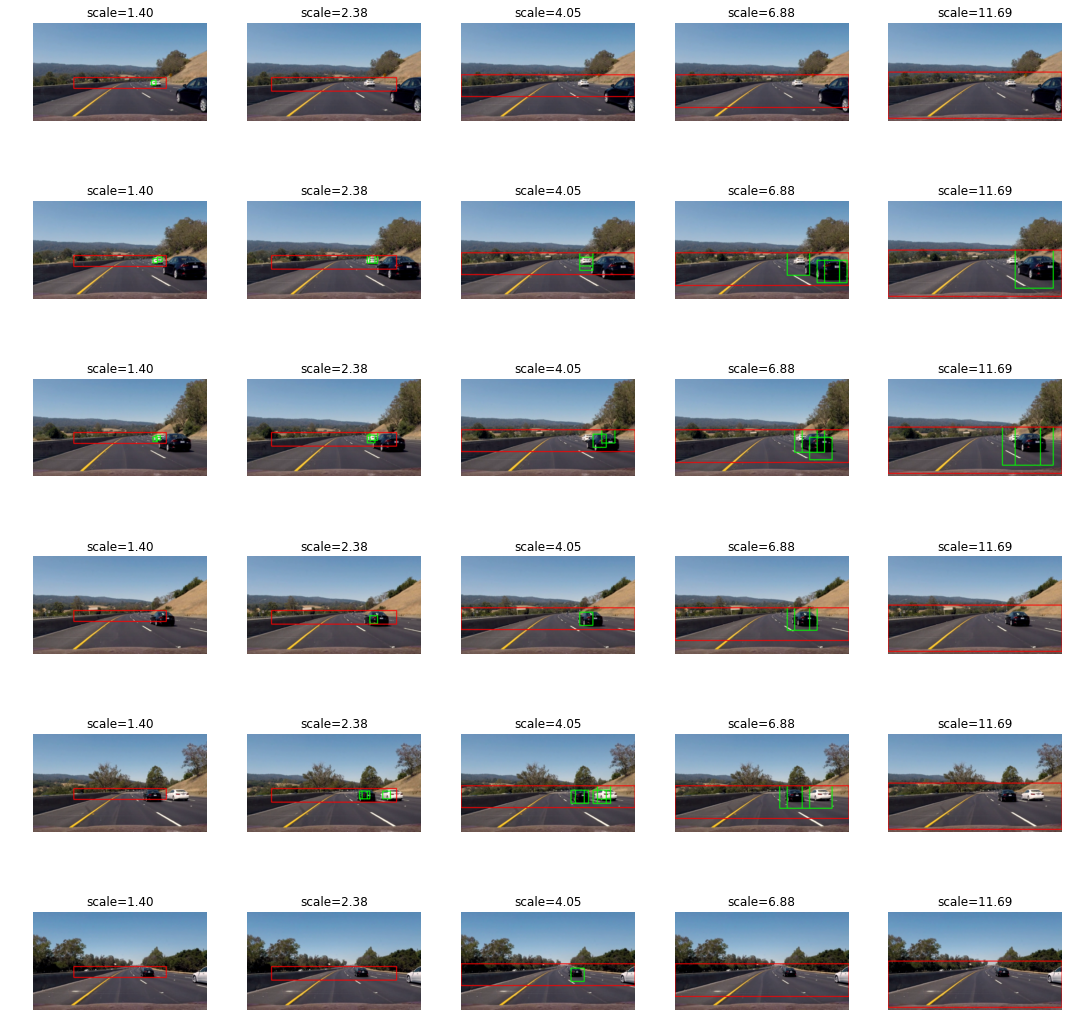

In [19]:
visualizeScaleAndExtraction()

### Multi-scale detector

In [20]:
# draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    #imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    #return imcopy

In [21]:
def findCarsMultiscale_720p(img, bVis=False):
    assert img.shape[0] == 720 and img.shape[1] == 1280
    allWnds = []
    for scalePow in range(SCALE_POW_SAMPLES):
        scale = SCALE_START * np.power(SCALE_STEP, scalePow)            
        wnds = findCars(img, XY_START_STOP[scalePow][0], XY_START_STOP[scalePow][1], scale, False)
        allWnds += wnds

    if bVis:
        outVis = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        draw_boxes(outVis, allWnds)
        return allWnds, outVis
    else:
        return allWnds

In [22]:
def visualizeMultiscaleBoxes():
    listImages = glob.glob('test_images/dist*.png')
    
    f, axarr = plt.subplots((len(listImages)+2)//3, 3, figsize=(15, 5))
    axarr = axarr.flatten()

    i = 0
    for fname in listImages:
        img = cv2.imread(fname)

        _, imgRects = findCarsMultiscale_720p(img, True)
        axarr[i].imshow(imgRects)
        axarr[i].set_title(fname)

        i += 1
    f.tight_layout()

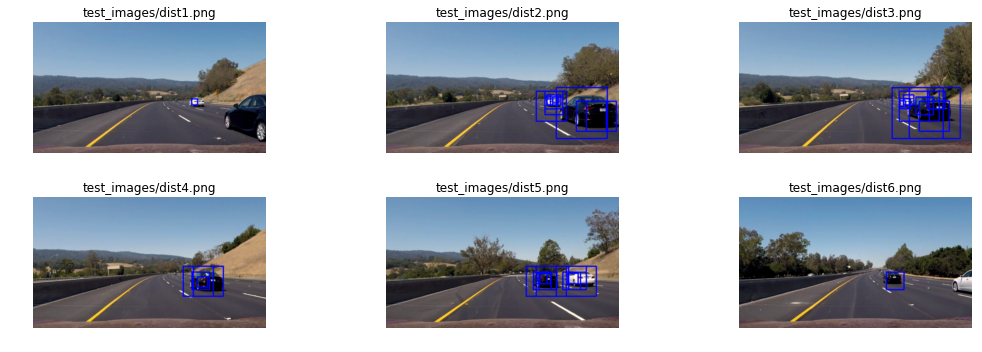

In [23]:
visualizeMultiscaleBoxes()

### Heatmap

In [24]:
# update heatmap with a list of detections from the current level
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# threshold the heatmap to get rid of weak detections
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [25]:
def convertWndsToHeatmap(img, wnds):
    heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    add_heat(heatmap, wnds)
    return heatmap

In [26]:
def visualizeHeatmap():
    img = cv2.imread('test_images/dist5.png')
    wnds = findCarsMultiscale_720p(img)
    heatmap = convertWndsToHeatmap(img, wnds)
    heatmap = apply_threshold(heatmap, 3)
    plt.imshow(heatmap, cmap='hot')

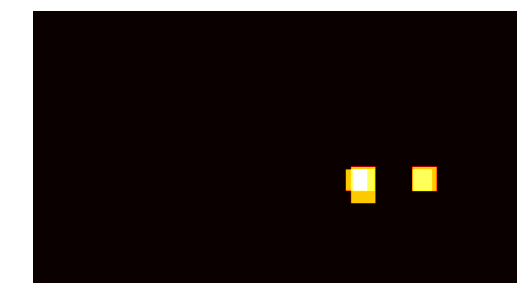

In [27]:
visualizeHeatmap()

### Label cars

In [28]:
# perform filtered heatmap segmentation into object labels
def connected_components(filteredHeatmap):
    return label(filteredHeatmap)

# visualize segmented objects using bounding boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,255), 6)
    # Return the image
    return img

In [29]:
def getFinalCarRects(img, heatmap):
    labels = connected_components(heatmap)
    return draw_labeled_bboxes(img, labels)

In [30]:
def visualizeCarLabels():
    img = cv2.imread('test_images/dist5.png')
    wnds = findCarsMultiscale_720p(img)
    heatmap = convertWndsToHeatmap(img, wnds)
    heatmap = apply_threshold(heatmap, 3)
    vis = getFinalCarRects(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), heatmap)
    plt.imshow(vis)

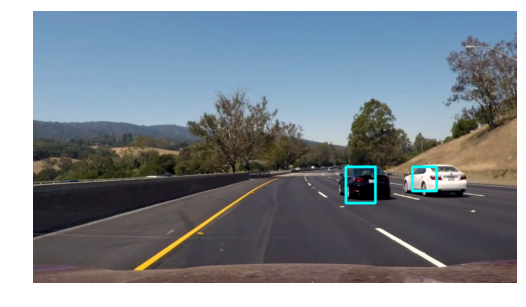

In [31]:
visualizeCarLabels()

### All steps together

In [32]:
def processImage(img):
    wnds, imgRects = findCarsMultiscale_720p(img, True)
    imgHeatmap = convertWndsToHeatmap(img, wnds)
    imgHeatmap = apply_threshold(imgHeatmap, 2)
    imgFinal = getFinalCarRects(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), imgHeatmap)
    imgHeatmap = cv2.resize(imgHeatmap, (imgHeatmap.shape[1]//2, imgHeatmap.shape[0]//2), cv2.INTER_AREA)
    #print(imgHeatmap.dtype, imgHeatmap.shape, np.amax(imgHeatmap), imgHeatmap)

    imgHeatmap = (255 * cm.hot(imgHeatmap.astype(np.float) / np.amax(imgHeatmap))[:,:,0:3]).astype(np.uint8)
    
    imgFinal[0:imgHeatmap.shape[0], 0:imgHeatmap.shape[1], :] = imgHeatmap[:,:,:]
    return imgFinal

In [33]:
def processImages():
    listImages = glob.glob('test_images/*')
    
    f, axarr = plt.subplots((len(listImages)+2)//3, 3, figsize=(15, 15))
    axarr = axarr.flatten()

    i = 0
    for fname in listImages:
        img = cv2.imread(fname)
        img = processImage(img)
        
        axarr[i].imshow(img)
        axarr[i].set_title(fname)

        i += 1
    f.tight_layout()

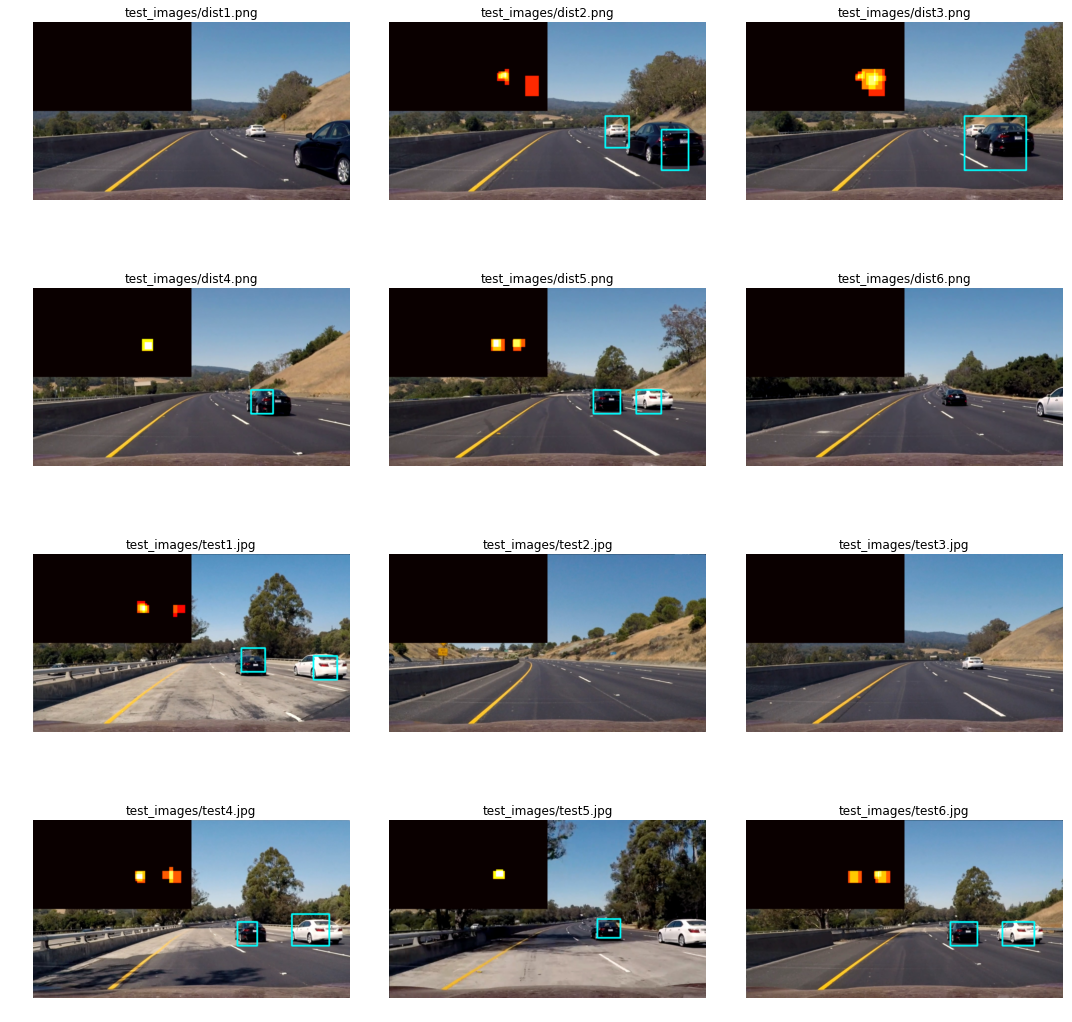

In [34]:
processImages()

## Video pipeline

In [35]:
def processVideo(nameIn, nameOut, startSec=None, endSec=None):
    vin = cv2.VideoCapture(nameIn)
    fps = vin.get(cv2.CAP_PROP_FPS)
    vout = None
    
    i = -1

    heatmapAcc = None
    
    cntMsHog = 0
    cntMsHeatmap = 0
    cntMsFramePrep = 0
    
    while(vin.isOpened()):
        i += 1
        ret, img = vin.read()
        if not ret:
            break

        if heatmapAcc is None:
            heatmapAcc = np.zeros((img.shape[0], img.shape[1]), dtype=np.float)
            
        if startSec is not None:
            if i < startSec * fps:
                continue
            if endSec is not None:
                if i > endSec * fps:
                    continue
            
        if vout == None and nameOut != None:
            outDims = (img.shape[1], img.shape[0])
            vout = cv2.VideoWriter(nameOut, cv2.VideoWriter_fourcc(*'XVID'), fps, outDims, True)

        t1 = nowMs()
        wnds = findCarsMultiscale_720p(img, False)
        t2 = nowMs()
        
        imgHeatmap = convertWndsToHeatmap(img, wnds)
        t3 = nowMs()
        
        heatmapAcc = heatmapAcc * 0.7 + imgHeatmap * 0.3
        imgHeatmap = apply_threshold(heatmapAcc, 1)
        t4 = nowMs()

        imgFinal = getFinalCarRects(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), heatmapAcc)
        t5 = nowMs()

        imgHeatmap = cv2.resize(heatmapAcc, (heatmapAcc.shape[1]//2, heatmapAcc.shape[0]//2), cv2.INTER_AREA)
        t6 = nowMs()

        imgHeatmap = (255 * cm.hot(imgHeatmap.astype(np.float) / np.amax(imgHeatmap))[:,:,0:3]).astype(np.uint8)

        imgFinal[0:imgHeatmap.shape[0], 0:imgHeatmap.shape[1], :] = imgHeatmap[:,:,:]
        t7 = nowMs()

        cntMsHog += (t2-t1)
        cntMsHeatmap += (t5-t2)
        cntMsFramePrep += (t7-t5)
        
        vout.write(cv2.cvtColor(imgFinal, cv2.COLOR_RGB2BGR))

    vin.release()
    if vout != None:
        vout.release()    
    
    cntMsHog /= i
    cntMsHeatmap /= i
    cntMsFramePrep /= i

    print('Processed {} frames, avg durations in ms for detection={}, heatmap={}, framePrep={}'
          .format(i, cntMsHog, cntMsHeatmap, cntMsFramePrep))


In [36]:
%time processVideo('test_video.mp4', 'test_video_out.mp4')

Processed 31 frames, avg durations in ms for detection=294.7096774193548, heatmap=16.483870967741936, framePrep=9.838709677419354
CPU times: user 10.3 s, sys: 222 ms, total: 10.6 s
Wall time: 10.3 s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_video_out.mp4'))

In [39]:
%time processVideo('project_video.mp4', 'project_video_out.mp4')

Processed 1253 frames, avg durations in ms for detection=293.74541101356743, heatmap=13.801276935355148, framePrep=8.934557063048683
CPU times: user 6min 49s, sys: 7.29 s, total: 6min 56s
Wall time: 6min 47s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))